In [1]:
import pandas as pd
import numpy as np
import argparse
import datetime
from copy import deepcopy # Add Deepcopy for args
import pickle 
import seaborn as sns 
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.api import SimpleExpSmoothing
from sklearn.model_selection import train_test_split

# pytorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
 
 
print(torch.__version__)
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (8, 6)

1.6.0+cpu
Populating the interactive namespace from numpy and matplotlib


In [157]:
# ================================================= #
def df2d_to_array3d(df_2d):
    
    # 입력 받은 2차원 데이터 프레임을 3차원 numpy array로 변경하는 함수
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    
    return array_3d
# ================================================= #


In [158]:
# ================================================= #

def simple_exponetial_smoothing_fory(arr, alpha=0.3):
    
    y_series = list()

    for temp_arr in arr:
        target_series = temp_arr[:, 1].reshape(-1) # open col is 1 index

        smoother = SimpleExpSmoothing(target_series, initialization_method="heuristic").fit(smoothing_level=alpha,optimized=False)
        smoothing_series = smoother.fittedvalues

        y_series.append(smoothing_series)
            
    return np.array(y_series)

# ================================================= #

def simple_exponetial_smoothing_forX(arr, alpha=0.3):
    
    # initialization
    sample_size = int(arr.shape[0])
    time_size = int(arr.shape[1])
    feature_size = int(arr.shape[2])
    
    # create empty array
    smoothing_arr = np.zeros((sample_size, time_size, feature_size - 1))

    for idx, temp_arr in enumerate(arr):
        for col in range(1, feature_size): # open col is 1 index
            if col < 5:

                temp_series = temp_arr[:, col].reshape(-1) 
                smoother = SimpleExpSmoothing(temp_series, initialization_method="heuristic").fit(smoothing_level=0.3,optimized=False)
                temp_smoothing_series = smoother.fittedvalues
                smoothing_arr[idx, :, col-1] = temp_smoothing_series

            else:
                
                pass_series = temp_arr[:, col].reshape(-1)
                smoothing_arr[idx, :, col-1] = pass_series

    return smoothing_arr

# ================================================= #

In [159]:
def getWeights_FFD(d, size, thres):
    w = [1.]  # w의 초깃값 = 1

    for k in range(1, size):
        w_ = -w[-1] * (d - k + 1) / k  # 식 2)를 사용했다.
        if abs(w[-1]) >= thres and abs(w_) <= thres:
            break

        else:
            w.append(w_)

    # w의 inverse
    w = np.array(w[::-1]).reshape(-1, 1)

    return w


def fracDiff_FFD(series, d, thres=0.002):
    '''

    Constant width window (new solution)

    Note 1: thres determines the cut-off weight for the window

    Note 2: d can be any positive fractional, not necessarily bounded [0,1]

    '''

    # 1) Compute weights for the longest series
    w = getWeights_FFD(d, series.shape[0], thres)
    width = len(w) - 1

    # 2) Apply weights to values
    df = []
    seriesF = series

    for iloc in range(len(w), seriesF.shape[0]):
        k = np.dot(w.T[::-1], seriesF[iloc - len(w):iloc])
        df.append(k)

    df = np.array(df)

    return df, w

In [160]:
# read file
raw_x_df = pd.read_csv('./data/train_x_df.csv')
raw_y_df = pd.read_csv('./data/train_y_df.csv')

print('Read files Complete!')

train_x_df = raw_x_df[raw_x_df.coin_index == 9]
train_y_df = raw_y_df[raw_y_df.coin_index == 9]
train_y_df['open'] = np.log(train_y_df['open'])

Read files Complete!


C:\Users\User\anaconda3\envs\jeongseup\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [161]:

# ================================================= #
# test_sample_list = [4176, 601, 1934, 947, 5025]

# test set split into X df
# test_x_df = raw_x_df[raw_x_df.sample_id.isin(test_sample_list)]
# train_x_df =  raw_x_df[~raw_x_df.sample_id.isin(test_sample_list)]

# train set
train_x_arr = df2d_to_array3d(train_x_df)
train_y_arr = df2d_to_array3d(train_y_df)

print(
    f'''
    train x shape is {train_x_arr.shape},
    train y shape is {train_y_arr.shape},
    '''
)


    train x shape is (1208, 1380, 10),
    train y shape is (1208, 120, 10),
    


In [162]:
# train set smoothing
train_x_arr = simple_exponetial_smoothing_forX(train_x_arr)
train_y_arr = simple_exponetial_smoothing_fory(train_y_arr)

# # test set smoothing 
# test_x_arr = simple_exponetial_smoothing_forX(test_x_arr)
print('simple exponetial smoothing Complete!!!')
print(train_x_arr.shape, train_y_arr.shape)

simple exponetial smoothing Complete!!!
(1208, 1380, 9) (1208, 120)


In [163]:
def train_val_test_spliter(arr):
    
    n = len(arr)
    num_features = arr.shape[2] - 1
    
    train_arr = arr[0:int(n*0.8), :, 1:]
    val_arr = arr[int(n*0.8):, :, 1:]
    
    n2 = len(train_arr) + len(val_arr)
    
    print(
    f'''
    ======================================================
    Origin length is {n}, then total split length is {n2}
    ======================================================
    train length is {train_arr.shape},
    val length is {val_arr.shape},
    num_features is ({num_features})
    '''
    )
    
    return train_arr, val_arr

In [164]:
print(
    f'''
    train x shape is {train_x_arr.shape},
    train y shape is {train_y_arr.shape},
    '''
    
#     test x shape is {test_x_arr.shape},
#     test y shape is {test_y_arr.shape},
)


    train x shape is (1208, 1380, 9),
    train y shape is (1208, 120),
    


In [165]:
# train & val set
train_X, val_X, train_y, val_y = train_test_split(train_x_arr, train_y_arr, test_size=0.1, shuffle=False)

# test set
# test_X = test_x_arr[:, :, 1:] # open col
# test_y = test_y_arr

In [166]:
print(
f'''
======================================================
Origin length is {len(train_x_arr)}, then total split length is {len(train_X)}
======================================================
train X length is {train_X.shape}, train y length is {train_y.shape},
val X length is {val_X.shape}, val y length is {val_y.shape},
'''
# test X length is {test_X.shape}, test y length is {test_y.shape}
)



Origin length is 1208, then total split length is 1087
train X length is (1087, 1380, 9), train y length is (1087, 120),
val X length is (121, 1380, 9), val y length is (121, 120),



In [167]:
def certain_col_normalization(train_x_arr):
    ''' 함수 설명 : 일부 열만 정규화 '''
    # create empty scaled list
    scaled_train_x_arr = np.zeros((train_x_arr.shape[0], train_x_arr.shape[1], train_x_arr.shape[2]))
    
    for temp_coin_num in unique_coin_index:
        # 유니크 코인 번호 중 한 코인 번호씩 해당 코인에 맞는 인덱스 추출
        # ex) if temp_coin_num is 0, temp_coin_index = [3, 7, 8, 14...]
        temp_coin_index = coin_index_export(train_x_arr, temp_coin_num)
        
        # temp coin num array export
        temp_x_arr = train_x_arr[temp_coin_index]
        
        # initialization
        num_sample   = temp_x_arr.shape[0] # sample dim
        num_sequence = temp_x_arr.shape[1] # time-sequence dim
        num_feature  = temp_x_arr.shape[2] # feature dim

        # create emptpy scaler
        temp_scaler = StandardScaler() 
        
        # 시계열을 선회하면서 피팅합니다
        print('Current normalizing coin number is {}'.format(temp_coin_num))
        for temp_sample, temp_index in enumerate(temp_coin_index):
            temp_scaler.partial_fit(temp_x_arr[temp_sample, :, :])

        # 스케일링(변환)합니다.
        for temp_sample, temp_index in enumerate(temp_coin_index):
            scaled_train_x_arr[temp_index, :, :] = temp_scaler.transform(temp_x_arr[temp_sample, :, :]).reshape(1, num_sequence, num_feature)
        

(1087, 1380, 9)

In [138]:
train_x_mean = train_X.mean(axis=(0, 1))
train_x_std = train_X.std(axis=(0, 1))

train_X = (train_X - train_x_mean) / train_x_std
val_X = (val_X - train_x_mean) / train_x_std
# test_X = (test_X - train_x_mean) / train_x_std

In [150]:
# ====== initialization
parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device is",args.device)

seed = 777
np.random.seed(seed)
torch.manual_seed(seed)


# ====== Model Capacity options ===== #
args.input_dim = 9
args.hidden_dim = 100
args.output_dim = 1
args.n_layers = 1
args.batch_size = 4
args.dropout = 0.2
args.use_bn = True

# ====== Dataset Generating options ====== #
args.x_frames = 255
args.y_frames = 120

# ====== Model training options ===== #
args.num_epoch = 100
args.learning_rate = 0.0002
args.L2_rate = 0.00001


device is cuda


In [151]:
class WindowGenerator():
    ''' Dataset Generate'''
    def __init__(self, X_arr, y_arr, x_frames):
    
        self.X_arr = X_arr
        self.y_arr = y_arr
        self.x_frames = x_frames
        
        
    def __repr__(self):
        return '\n'.join([
            f'Input indices: {self.X_arr.shape}',
            f'Label indices: {len(self.y_arr)}',
            f'Current column name(s): {self.x_frames}'
        ])

    def __len__(self):
        return len(self.y_arr)

    def __getitem__(self, idx):
        
        X = self.X_arr[idx, -self.x_frames:, :]
        y = self.y_arr[idx, :]

        return X, y

In [152]:
class LSTM(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout, use_bn):
        super(LSTM, self).__init__()
        self.input_dim = input_dim 
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers

        self.dropout = dropout
        self.use_bn = use_bn 
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)

        self.regressor = self.make_regressor()
        
    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, batch_size, self.hidden_dim))
    
    def make_regressor(self):
        layers = []
        if self.use_bn:
            layers.append(nn.BatchNorm1d(self.hidden_dim))
        layers.append(nn.Dropout(self.dropout))
        
        layers.append(nn.Linear(self.hidden_dim, 200))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(200, self.output_dim))
        regressor = nn.Sequential(*layers)
        return regressor
    
    def forward(self, X):
        lstm_out, self.hidden = self.lstm(X)
        y_pred = self.regressor(lstm_out[-1].view(X.shape[1], -1))
        return y_pred
    


    
def train(model, partition, optimizer, loss_fn, args):
    ''' model training '''
   
    # data load
    trainloader = DataLoader(partition['train'],
                             batch_size = args.batch_size,
                             shuffle = True, drop_last = True)
    
    # model's mode setting
    model.train()
    model.zero_grad()
    
    train_loss = 0.0
    
    for i, (X, y) in enumerate(trainloader):
    
        X = X.transpose(0, 1).float().to(args.device)
        y_true = y.float().to(args.device)
        
#         print(X.shape, y_true.shape)
        
        # zero the gradient
        optimizer.zero_grad()

        model.hidden = model.init_hidden(X.shape[1])

        y_pred = model(X)
#         print(y_pred.shape)
        
        loss = loss_fn(y_true.view(-1), y_pred.view(-1))
        loss.backward()
        optimizer.step()
        
        # get the batch loss
        train_loss += loss.item()
        
    train_loss = train_loss / len(trainloader)
    # train_loss = train_loss*10E5
    return model, train_loss


def validate(model, partition, loss_fn, args):
    ''' model validate '''
    
    # data load
    valloader = DataLoader(partition['val'], 
                           batch_size = args.batch_size, 
                           shuffle = False, drop_last = True)
    
    # model's mode setting
    model.eval()
    val_loss = 0.0
    
    # evaluate
    with torch.no_grad():
        for i, (X, y) in enumerate(valloader):
            
            X = X.transpose(0, 1).float().to(args.device)
            y_true = y.float().to(args.device)
            
            model.hidden = model.init_hidden(X.shape[1])
            # en-decoder outputs tensor 
            y_pred = model(X)
            # compute the loss 
            loss = loss_fn(y_true.view(-1), y_pred.view(-1))

            # get the batch loss
            val_loss += loss.item()
            
    val_loss = val_loss / len(valloader)
    # val_loss = val_loss * 10E5
    return val_loss



def experiment(partition, args):


    model = LSTM(args.input_dim, args.hidden_dim, args.y_frames, args.n_layers, args.dropout, args.use_bn)
    model.to(args.device)
    
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.L2_rate)
    
    # epoch-wise loss
    train_losses = []
    val_losses = []

    for epoch in range(args.num_epoch):
        
        start_time = time.time()
        model, train_loss = train(model, partition, optimizer, loss_fn, args)
        val_loss = validate(model, partition, loss_fn, args)
        end_time = time.time()
        
        # add epoch loss
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        print('Epoch {},Loss(train/val) {:.3f}/{:.3f}. Took {:.2f} sec'.format(epoch+1, train_loss * 10E3, val_loss * 10E3, end_time-start_time))
    
    
    # ======= Add Result to Dictionary ======= #
    result = {}
    
    result['train_losses'] = train_losses #epoch 수에 의존
    result['val_losses'] = val_losses 
     
    return vars(args), result, model

In [153]:
trainset = WindowGenerator(train_X, train_y, x_frames = args.x_frames)
valset = WindowGenerator(val_X, val_y, x_frames = args.x_frames)
# testset = WindowGenerator(test_X, test_y, x_frames = args.x_frames)

partition = {'train': trainset, 'val':valset}

In [154]:
print(args)
setting, result, model = experiment(partition, deepcopy(args))

Namespace(L2_rate=1e-05, batch_size=4, device='cuda', dropout=0.2, hidden_dim=100, input_dim=9, learning_rate=0.0002, n_layers=1, num_epoch=100, output_dim=1, use_bn=True, x_frames=255, y_frames=120)
Epoch 1,Loss(train/val) 10276.683/25429.179. Took 2.36 sec
Epoch 2,Loss(train/val) 10136.463/25454.863. Took 2.19 sec
Epoch 3,Loss(train/val) 10095.137/25339.167. Took 2.18 sec
Epoch 4,Loss(train/val) 10094.990/25150.650. Took 2.18 sec
Epoch 5,Loss(train/val) 10109.772/25423.866. Took 2.18 sec
Epoch 6,Loss(train/val) 10046.063/25293.084. Took 2.17 sec
Epoch 7,Loss(train/val) 9980.408/25398.512. Took 2.17 sec
Epoch 8,Loss(train/val) 9905.939/25464.630. Took 2.16 sec
Epoch 9,Loss(train/val) 9960.301/25309.126. Took 2.24 sec
Epoch 10,Loss(train/val) 9699.552/26275.498. Took 2.20 sec
Epoch 11,Loss(train/val) 9929.416/25337.195. Took 2.20 sec
Epoch 12,Loss(train/val) 9786.535/25214.344. Took 2.22 sec
Epoch 13,Loss(train/val) 9806.876/25654.189. Took 2.23 sec
Epoch 14,Loss(train/val) 9823.540/25

(120,) (120,)


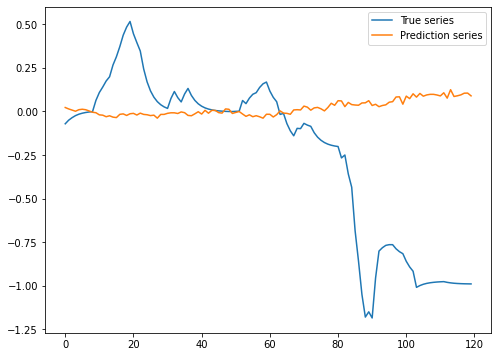

(120,) (120,)


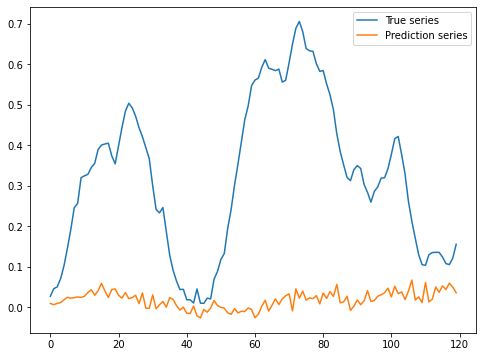

(120,) (120,)


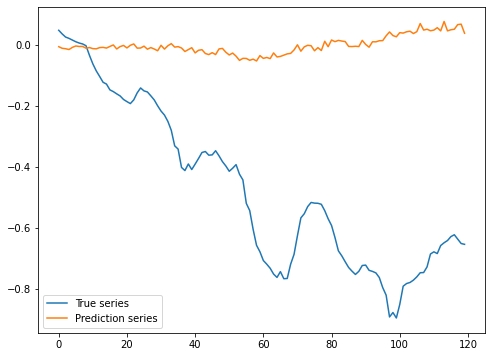

(120,) (120,)


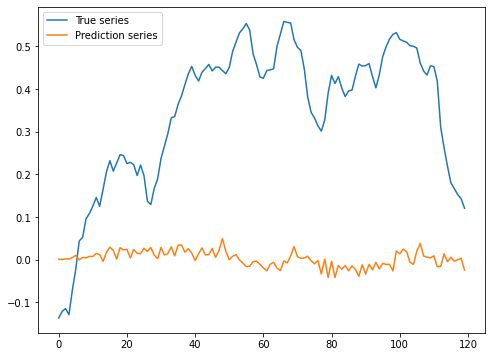

(120,) (120,)


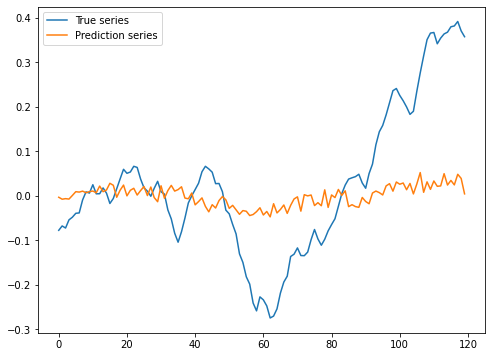

(120,) (120,)


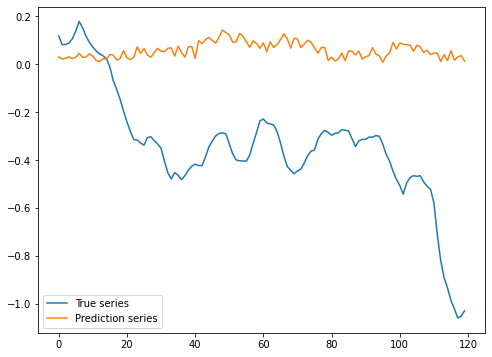

Namespace(L2_rate=1e-05, batch_size=4, device='cuda', dropout=0.2, hidden_dim=100, input_dim=9, learning_rate=0.0002, n_layers=1, num_epoch=100, output_dim=1, use_bn=True, x_frames=255, y_frames=120) 
SES 사용
mean absolute error * 10E5 is 83474.57647323608


In [155]:
testloader = DataLoader(partition['train'], batch_size = 1, shuffle = True, drop_last = True)
model.eval()
# evaluate

with torch.no_grad():
    for i, (X, y) in enumerate(testloader):

        X = X.transpose(0, 1).float().to(args.device)
        y_true = y.float().to(args.device)
        model.hidden = model.init_hidden(X.shape[1])

        # en-decoder outputs tensor 
        y_pred = model(X)
        
        # y values to cpu
        y_true = y_true.cpu().detach().numpy().reshape(-1)
        y_pred = y_pred.cpu().detach().numpy().reshape(-1)

        print(y_true.shape, y_pred.shape)

        plt.plot(y_true, label = 'True series')
        plt.plot(y_pred, '-', label = 'Prediction series')

        plt.legend()
        plt.show()

        loss = mean_absolute_error(y_true, y_pred)
        mae =+ loss

        if i == 5:
          print(args, "\nSES 사용")
          print(f'mean absolute error * 10E5 is {(mae/5) * 10E5}')     
          break      

